# Big Data Analytics project - Group 04

This work was developed by:

- Daniel Caridade (20211588)
- Gonçalo Teles (20211684)
- Gonçalo Peres (20211625)
- Guilherme Godinho (20211552)
- Vinicius Pinto (20211682)

To run this notebook, it is necessary to use a ML cluster, since Graph Frames does not work with Databricks Standard clusters.

# 0. Packages installation

Uncomment and run the following cell of code to install required libraries to eu this notebook.

In [0]:
# Only run once
#%pip install graphframes
#%pip install scipy==1.11.4

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c4ef5cc6-e48a-427d-a7ca-a17f38fbd17c
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Not uninstalling scipy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c4ef5cc6-e48a-427d-a7ca-a17f38fbd17c
    Can't uninstall 'scipy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
databricks

# 1. Library Importation

__`Step 1`__ Importing the necessary libraries.

In [0]:
# Data Integration
from pyspark.sql import SparkSession

# Graph Frames
import pandas as pd
import networkx as nx
import scipy
import numpy as np
import matplotlib.pyplot as plt
from graphframes import GraphFrame
from pyspark.sql import functions as F
from matplotlib import cm, colors

# 2. Data Integration

__`Step 2`__ Creating the Spark Session.

In [0]:
spark = SparkSession.builder \
    .appName("BDA_Project") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.1-s_2.12") \
    .getOrCreate()

__`Step 3`__ Importing the cleaned dataset that ws stored in Databricks in the first notebook.

In [0]:
# Loading the dataset
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/FileStore/df_cleaned_output")

# Displaying the first 5 rows
df.show(5)

+----------+-------------+----------+---------+--------------------+-----+--------+--------------+-------+
|CustomerNo|TransactionNo|      Date|ProductNo|         ProductName|Price|Quantity|       Country|cluster|
+----------+-------------+----------+---------+--------------------+-----+--------+--------------+-------+
|     13047|       536367|2018-12-01|    22745|Poppy's Playhouse...| 12.4|       6|United Kingdom|      1|
|     13047|       536367|2018-12-01|    22749|Feltcraft Princes...|14.09|       8|United Kingdom|      1|
|     13047|       536367|2018-12-01|    84969|Box Of 6 Assorted...|14.61|       6|United Kingdom|      1|
|     12583|       536370|2018-12-01|    21913|Vintage Seaside J...|14.09|      12|        France|      1|
|     17850|       536373|2018-12-01|    21730|Glass Star Froste...|14.61|       6|United Kingdom|      0|
+----------+-------------+----------+---------+--------------------+-----+--------+--------------+-------+
only showing top 5 rows



# 3. Graph Frames

## 3.1. Product Influence Analysis

__`Step 4`__ Creating Vertices and Edges to build the graph of relationships between products. 

- Vertices: Products.
- Edges: Pairs of products bought together in the same transaction.

In [0]:
# Vertices: Products with names
vertices = df.select("ProductNo", "ProductName") \
    .dropna().dropDuplicates(["ProductNo"]) \
    .withColumnRenamed("ProductNo", "id")

# Edges: Products bought together in the same transaction
product_pairs = df.alias("a").join(
    df.alias("b"),
    (F.col("a.TransactionNo") == F.col("b.TransactionNo")) &
    (F.col("a.ProductNo") < F.col("b.ProductNo"))
).select(
    F.col("a.ProductNo").alias("src"),
    F.col("b.ProductNo").alias("dst")
).dropDuplicates()

# Build graph
product_graph = GraphFrame(vertices, product_pairs)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


__`Step 5`__ Ranking Products by Influence Using PageRank.

In [0]:
# Run PageRank
pagerank_results = product_graph.pageRank(resetProbability=0.15, maxIter=10)

# Select only needed columns from 'vertices' before joining
clean_vertices = vertices.select("id", "ProductName").alias("v")
pagerank_df = pagerank_results.vertices.alias("pr")

# Join clean vertices to get product names
top_influential = (
    pagerank_df
    .join(clean_vertices, on="id", how="left")
    .select("pr.id", "v.ProductName", "pr.pagerank")
    .orderBy("pr.pagerank", ascending=False)
)

top_influential.show(30, truncate=False)

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+------+---------------------------------+------------------+
|id    |ProductName                      |pagerank          |
+------+---------------------------------+------------------+
|90214Z|"Letter ""Z"" Bling Key Ring"    |252.5839074820507 |
|90214Y|"Letter ""Y"" Bling Key Ring"    |128.52563057251027|
|90214W|"Letter ""W"" Bling Key Ring"    |85.84350362324076 |
|90214V|"Letter ""V"" Bling Key Ring"    |68.50655914413613 |
|90214S|"Letter ""S"" Bling Key Ring"    |51.10839375527585 |
|90214U|"Letter ""U"" Bling Key Ring"    |49.87063593940894 |
|90214T|"Letter ""T"" Bling Key Ring"    |46.35752737023146 |
|90214R|"Letter ""R"" Bling Key Ring"    |40.59142677206383 |
|90214P|"Letter ""P"" Bling Key Ring"    |38.44796721273263 |
|90214N|"Letter ""N"" Bling Key Ring"    |34.74391566202747 |
|90214L|"Letter ""L"" Bling Key Ring"    |31.787507777594485|
|90214K|"Letter ""K"" Bling Key Ring"    |28.461138365935128|
|90214J|"Letter ""J"" Bling Key Ring"    |28.27336678397671 |
|90214M|

__`Step 5.1`__ Checking the least influential products.

In [0]:
# Show 30 least influential products by PageRank
top_influential.orderBy("pagerank", ascending=True).show(30, truncate=False)

+------+-----------------------------------+-------------------+
|id    |ProductName                        |pagerank           |
+------+-----------------------------------+-------------------+
|20793 |Blue Tiled Tray                    |0.18850742309585322|
|16202A|Pastel Pink Photo Album            |0.18850742309585322|
|23843 |Paper Craft Little Birdie          |0.18850742309585322|
|10080 |Groovy Cactus Inflatable           |0.18850742309585322|
|10002 |Inflatable Political Globe         |0.18850742309585322|
|10124A|Spots On Red Bookcover Tape        |0.18850742309585322|
|15030 |Fan Black Frame                    |0.18850742309585322|
|16169N|Wrap Blue Russian Folkart          |0.18850742309585322|
|22275 |Weekend Bag Vintage Rose Paisley   |0.18850742309585322|
|21655 |Hanging Ridge Glass T-Light Holder |0.18850742309585322|
|17001 |Heavens Scent Fragrance Oils Asstd |0.18850742309585322|
|21491 |Set Of Three Vintage Gift Wraps    |0.18850742309585322|
|72803B|Ocean Scent Candl

__`Step 6`__ Visualizing the top influential products as a Network Graph.

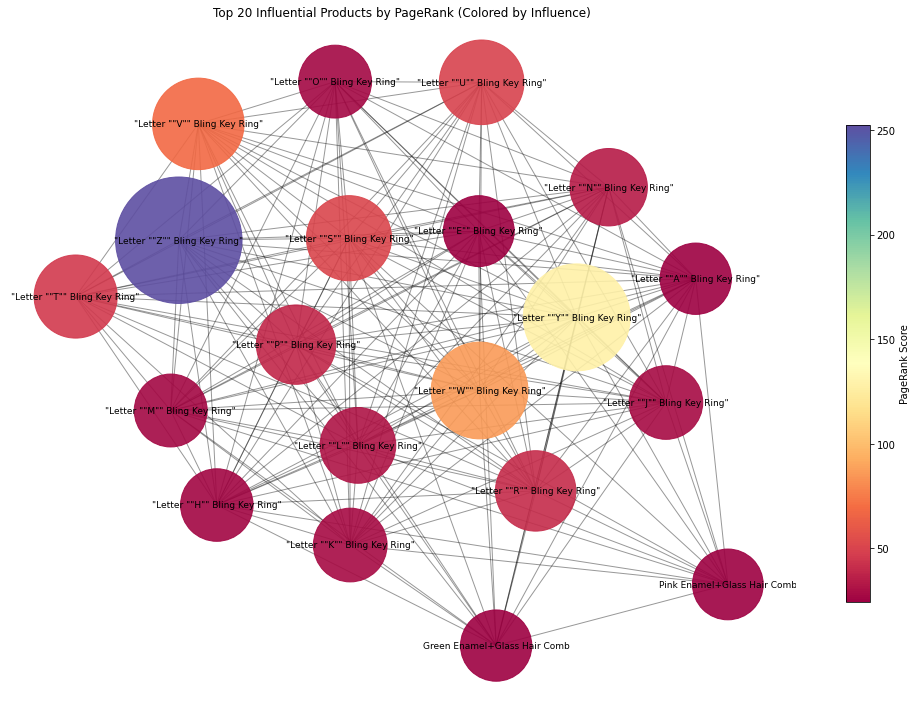

In [0]:
# Convert edges and PageRank to Pandas
pagerank_pd = top_influential.toPandas()
edges_pd = product_pairs.toPandas()

# Create NetworkX graph
G = nx.Graph()

# Add nodes with labels and PageRank
for _, row in pagerank_pd.iterrows():
    G.add_node(row['id'], label=row['ProductName'], pagerank=row['pagerank'])

# Add edges (undirected co-purchases)
for _, row in edges_pd.iterrows():
    G.add_edge(row['src'], row['dst'])

# Get top 20 by PageRank
top_nodes = sorted(pagerank_pd[['id', 'pagerank']].values, key=lambda x: x[1], reverse=True)[:20]
top_node_ids = {node[0] for node in top_nodes}
G_sub = G.subgraph(top_node_ids).copy()

# Layout
pos = nx.spring_layout(G_sub, k=0.5, seed=42)

# Prepare node sizes and colors based on PageRank
pagerank_dict = nx.get_node_attributes(G_sub, 'pagerank')
pagerank_values = np.array([pagerank_dict[n] for n in G_sub.nodes()])
node_sizes = [100 + 1000 * np.sqrt(p) for p in pagerank_values]

# Normalize for colormap
norm = colors.Normalize(vmin=pagerank_values.min(), vmax=pagerank_values.max())
cmap = cm.Spectral  # Use vivid colormap (red, yellow, green, blue)
node_colors = [cmap(norm(p)) for p in pagerank_values]

# Labels
labels = {n: G_sub.nodes[n]['label'] for n in G_sub.nodes()}

# Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G_sub, pos, alpha=0.4)
nx.draw_networkx_labels(G_sub, pos, labels, font_size=9)

# Optional colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.7)
cbar.set_label('PageRank Score')

plt.title("Top 20 Influential Products by PageRank (Colored by Influence)")
plt.axis('off')
plt.tight_layout()
plt.show()

**Main conclusion from this analysis**

Our team applied the **PageRank algorithm** to our product co-purchase network to identify which products play the most influential role in transactions — not just by popularity, but by how *connected* they are to other products.

---

**📌 Key Insights:**

1. **Top Influential Product**  
   - 🏆 **"Letter Z Bling Key Ring"** stands out as the most influential item. It's frequently bought with many other products, making it a strong candidate for promotions or placement in key areas (e.g., homepages, checkout suggestions).

2. **Key Rings Dominate**  
   - 🔑 Most top-ranked products are **letter-based key rings**, especially with letters like **Z, Y, and V**. These likely reflect personalization trends (e.g., initials) of the person buying them or of the person they want to gift them to, making them excellent for bundling or personalization-driven marketing.

3. **Bundling Opportunities**  
   - 🎁 Hair accessories like **"Green Enamel+Glass Hair Comb"** appear in the top 20 but with lower scores. These products could benefit from **being bundled** with more influential items like key rings to boost visibility and sales.

4. **Cross-Category Signals**  
   - While most strong connections are within the same product type, there are **some links between categories** (e.g., key rings and hair combs), indicating a chance to create thoughtful, curated bundles or gift sets.

---

**💡 Business Takeaways:**

- **🛒 Drive Sales with Strategic Bundles**  
  Combine highly influential products (like popular key rings) with lower-ranked ones to lift overall sales.

- **📦 Optimize Inventory & Marketing**  
  Focus stock and campaigns on top-performing letters and styles. This way buying the most purchased ones in higher quantities since they drive more sales.

- **🎯 Target Promotions Intelligently**  
  Use influential products as anchors in email campaigns, homepage banners, or "frequently bought together" sections.

---

This network-driven approach represents a novel and innovative way to analyze product performance — not just by sales volume, but by how products connect and influence each other in real purchasing behavior.

By using graph theory and PageRank, we're no longer just looking at what sells the most — we're uncovering which products truly drive customer behavior. This allowed us to spot hidden gems that quietly influence sales, like the Key chains importance, that was not discover before using natural product pairings customers already tend to buy together, and revealed personalization trends the business can use to make smarter, more targeted offers.